In [2]:
import torch
import torchvision.transforms as transforms

import os
import random
from PIL import Image
import random
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

from dataset import HAM1000Dataset

/home/kamil/Pulpit/aso22l-medical-image-reidentification/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
random.seed(42)

In [29]:
MODEL_PATH = 'models/model_9.pth'
model = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.eval()

ReidentificationModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [30]:
DATASET_DIRECTORY = './dataset/HAM10000'
test_dataset = HAM1000Dataset(DATASET_DIRECTORY, split='test')

reference_set_embeddings = []

with torch.no_grad():
  for instance in tqdm(test_dataset.dataset_metadata):
    image_name = instance['image_name']
    diagnosis = instance['diagnosis']

    image_path = os.path.join(
              DATASET_DIRECTORY, 'images', f'{image_name}.jpg')
    image = Image.open(image_path)

    transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                                0.229, 0.224, 0.225]),
      ])
    tensor = transform(image).unsqueeze(dim=0)

    embedding_vector = model.forward_single(tensor)
    reference_set_embeddings.append({
      'image_name': image_name,
      'diagnosis': diagnosis,
      'embedding': embedding_vector
    })

with open('embeddings.pickle', 'wb') as embeddings_file:
  pickle.dump(reference_set_embeddings, embeddings_file)

100%|██████████| 1002/1002 [01:20<00:00, 12.44it/s]


In [31]:
reference_set_embeddings = []
with open('embeddings.pickle', 'rb') as embeddings_file:
  reference_set_embeddings = pickle.load(embeddings_file)

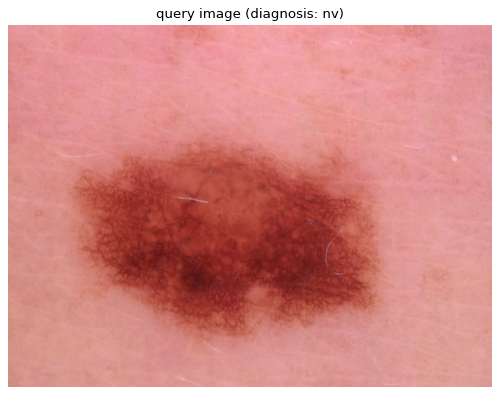

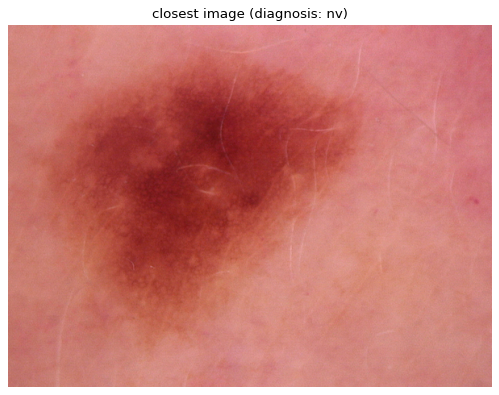

In [109]:
val_dataset = HAM1000Dataset(DATASET_DIRECTORY, split='val')

query_image_matadata = random.choice(val_dataset.dataset_metadata)
query_image_name = query_image_matadata['image_name']
query_dx = query_image_matadata['diagnosis']

query_path = os.path.join(
              DATASET_DIRECTORY, 'images', f'{query_image_name}.jpg')
query_image = Image.open(query_path)

transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                                0.229, 0.224, 0.225]),
])
query = transform(query_image).unsqueeze(dim=0)
query_embedding = model.forward_single(query)

best_distance = None
best_image = None

for candidate in reference_set_embeddings:
  emb = candidate['embedding']
  distance = torch.cdist(query_embedding, emb)
  if best_distance is None or distance < best_distance:
    best_distance = distance
    best_image = candidate

closest_image_path = os.path.join(
              DATASET_DIRECTORY, 'images', f'{best_image["image_name"]}.jpg')
closest_image = Image.open(closest_image_path)

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(query_image)
plt.title(f'query image (diagnosis: {query_dx})')
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(closest_image)
plt.title(f'closest image (diagnosis: {best_image["diagnosis"]})')
plt.axis('off')
plt.show()

In [112]:
correct = 0
total = 200

query_images_matadata = random.choices(val_dataset.dataset_metadata, k=total)
for query_image_metadata in query_images_matadata:
  query_image_name = query_image_metadata['image_name']
  query_dx = query_image_metadata['diagnosis']

  query_path = os.path.join(
                DATASET_DIRECTORY, 'images', f'{query_image_name}.jpg')
  query_image = Image.open(query_path)

  transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                                  0.229, 0.224, 0.225]),
  ])
  query = transform(query_image).unsqueeze(dim=0)
  query_embedding = model.forward_single(query)

  best_distance = None
  best_image = None

  for candidate in reference_set_embeddings:
    emb = candidate['embedding']
    distance = torch.cdist(query_embedding, emb)
    if best_distance is None or distance < best_distance:
      best_distance = distance
      best_image = candidate

  if best_image['diagnosis'] == query_dx:
    correct += 1

print(f'Closest images with the same diagnosis: {100.0 * correct / total}%')

Closest images with the same diagnosis: 55.5%
